# SRE ReAct agent with custom schema and RAG (to store mitigation plans)

This notebook implements an intelligent Site Reliability Engineering (SRE) agent that automatically diagnoses Kubernetes incidents and generates mitigation plans. The agent uses a ReAct (Reasoning + Acting) framework powered by LangGraph to:

- **Investigate incidents** using kubectl tools through MCP (Model Context Protocol) servers
- **Analyze cluster state** and extract meaningful insights from Kubernetes resources
- **Generate structured diagnosis** with detailed reasoning and root cause analysis
- **Create mitigation plans** by leveraging ChromaDB RAG to search for similar past incidents
- **Provide comprehensive reports** with step-by-step remediation guidance

In [89]:
from dotenv import load_dotenv
import os

# Set env variables from file
load_dotenv()

True

In [90]:
chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

## Testing the RAG (ChromaDB)

In [91]:
from chromadb import PersistentClient

chroma_client = PersistentClient(path=chromaDB_path)

incidents_collection = chroma_client.get_or_create_collection("incidents")

# Get all the docs in the collection
incidents_collection.peek()

{'ids': ['a27c328e-b573-4463-a2b3-9c1bc32d58e6',
  '2a61957b-996e-493d-b186-5f5ccc82338b'],
 'embeddings': array([[ 6.70451075e-02, -2.13284642e-02,  2.17653401e-02,
          4.55448925e-02, -5.73861506e-03, -4.59627621e-02,
          4.53623496e-02, -5.00395969e-02,  4.57851551e-02,
          3.29204798e-02, -1.09109385e-02, -8.50805193e-02,
         -2.46740822e-02, -1.22952955e-02,  4.03799005e-02,
         -2.45536007e-02,  5.99781200e-02, -7.49116857e-03,
         -3.27832364e-02, -2.38336436e-02,  3.29326130e-02,
          8.14366248e-03, -3.08141438e-03,  1.31960018e-02,
         -8.35228898e-03,  2.18658559e-02, -4.80365902e-02,
          1.19744232e-02,  1.32892309e-02, -6.18577525e-02,
         -7.54111446e-03,  4.97136936e-02,  1.84784289e-02,
          4.55506034e-02,  1.47869885e-01,  1.18755400e-01,
          7.92945269e-03, -6.49270192e-02, -4.15613241e-02,
          1.64432712e-02,  5.08863106e-03, -6.27124459e-02,
         -1.81484669e-02,  1.08183175e-03,  3.42151411

## Building SRE ReAct agent

In [92]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

gpt5 = ChatOpenAI(model="gpt-5")
gpt5mini = ChatOpenAI(model="gpt-5-mini")
gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLEAI_API_KEY") # Google AI Studio free api key
)

In [ ]:
from langchain_mcp_adapters.client import MultiServerMCPClient

chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

client = MultiServerMCPClient(
    {
        "kubernetes" : {
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        },
        "chroma": {
            "command": "uvx",
            "transport": "stdio",
            "args": [
                "chroma-mcp",
                "--client-type",
                "persistent",
                "--data-dir",
                str(chromaDB_path)
            ]
        }
    }
)

# NB: The cluster has to be running otherwise the tools won't be available
mcp_tools = await client.get_tools()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [94]:
#list all the tools
for tool in mcp_tools:
    print(f"🔧 {tool.name}")

🔧 kubectl_get
🔧 kubectl_describe
🔧 kubectl_apply
🔧 kubectl_create
🔧 kubectl_logs
🔧 kubectl_scale
🔧 kubectl_patch
🔧 kubectl_rollout
🔧 kubectl_context
🔧 explain_resource
🔧 install_helm_chart
🔧 upgrade_helm_chart
🔧 port_forward
🔧 stop_port_forward
🔧 exec_in_pod
🔧 list_api_resources
🔧 ping
🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents


In [95]:
# Tools allowed
tools_allowed = ["kubectl_get", "kubectl_describe", "kubectl_logs", "explain_resource", "list_api_resources", "ping"]

tools = []
chroma_tools = []

for tool in mcp_tools:
    # Remove not allowed MCP tools
    if tool.name in tools_allowed:
        tools.append(tool)
    # Create a custom list for ChromaDB tools
    elif "chroma" in  tool.name:
        chroma_tools.append(tool)

In [96]:
for tool in tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 list_api_resources: List the API resources available in the cluster
🔧 ping: Verify that the counterpart is still responsive and the connection is alive.


In [97]:
# List of chromaDB tools
for tool in chroma_tools:
    print(f"🔧 {tool.name}")

🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents


In [98]:
from typing import TypedDict, List, Literal, Annotated
from langgraph.graph.message import add_messages, AnyMessage
import operator

class SREAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    app_summary: str
    insights: Annotated[list[str], operator.add]
    prev_steps: Annotated[list[str], operator.add]
    response: str
    final_output: str
    mitigation_plan_overview: str
    mitigation_steps: List[str]
    is_already_happened: bool

In [99]:
sre_agent_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the Kubernetes cluster.

    Context:

    *Previous Steps:*
    {prev_steps}

    *Insights:*
    {insights}

    Your task:
        1. Begin by analyzing the service's state and telemetry using kubectl tools
        2. When you have identified the issue, call the submit_final_diagnosis tool with:
            - diagnosis: Describe the issue you have identified (without fixing it)
            - reasoning: Explain your reasoning and thought process behind the solution

    IMPORTANT: You must call submit_final_diagnosis when you're ready to conclude your investigation.
"""

In [100]:
summarise_prompt = """
    You are an autonomous SRE agent for Kubernetes incident diagnosis.

    Context:

    Previous Insights: 
    {insights}
    
    Previous Steps:
    {prev_steps}

    Below are the latest two messages:
    {last_two_messages}

    Instructions:
    1. From the latest two messages, extract the most important new insight relevant for incident diagnosis or mitigation. Summarize it concisely.
    2. Write a concise description of only the most recent action taken including the tool used (not the whole list).  
"""

In [101]:
def get_insights_str(state):
    """Return a string with the formatted list of insights gathered during exploration"""
    if len(state["insights"]) > 0:
        return "\n- ".join([""] + state["insights"])
    else:
        return "No insights yet"
    
def get_prev_steps_str(state):
    """Return a string with the formatted list of previous steps performed during exploration"""
    if len(state["prev_steps"]) > 0:
        return "\n- ".join([""] + state["prev_steps"])
    else:
        return "No previous steps yet"

### Extract insights node

In [102]:
from pydantic import BaseModel, Field

class UpdateAgentData(BaseModel):
    """
    Represents a step performed by the SRE agent.
    """
    insight: str = Field(..., description="Most important new finding")
    prev_step: str = Field(..., description="Concise description of the most recent action taken")

In [103]:
llm_with_strct_output = gpt5mini.with_structured_output(UpdateAgentData)

In [104]:
from langchain_core.messages import HumanMessage

# Node used to summarise the infos given the two previous messages
async def summarise(state: SREAgentState):

    # Gather last two messages (tool call + tool response)
    last_messages = state["messages"][-2:]

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=summarise_prompt.format(
        prev_steps = prev_step_str,
        insights=insights_str,
        last_two_messages=last_messages))

    data = llm_with_strct_output.invoke([prompt])

    return {"insights" : [data.insight], "prev_steps" : [data.prev_step]}

### SRE Agent node

In [105]:
from typing import Annotated
from langgraph.types import Command
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId

# Tool used to submit the final response
@tool
def submit_final_diagnosis(
    diagnosis: str, 
    reasoning: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Submit the final diagnosis when investigation is complete.
    
    Args:
        diagnosis: The issue you have identified (without fixing it)
        reasoning: Your reasoning and thought process behind the diagnosis
    
    Returns:
        Command to update state and end workflow
    """
    final_response = f"Diagnosis:\n{diagnosis}\n\nReasoning:\n{reasoning}"
    
    return Command(
        update={
            "response": final_response, # Add in the final graph state the final answer
            "messages": [
                ToolMessage(
                    content="Final diagnosis submitted successfully. Investigation complete.",
                    tool_call_id=tool_call_id
                )
            ]
        },
        goto="format-output" # End the loop cycle
    )

# Append the tool for submission to the list of tools (MCP servers)
completion_tool = submit_final_diagnosis
tools_with_completion = tools + [completion_tool]

In [106]:
async def sreAgent(state: SREAgentState):

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=sre_agent_prompt.format(
        prev_steps=prev_step_str, 
        insights=insights_str, 
        app_summary=state["app_summary"]
    ))

    # Use tools with completion (for the submission)
    llm_with_completion_tools = gpt5mini.bind_tools(tools_with_completion, parallel_tool_calls=False)
    return {"messages": [llm_with_completion_tools.invoke([prompt])]}

In [107]:
async def format_response(state: SREAgentState):
    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    message = "# 📝 Results of the Analysis\n\n"

    # Steps performed
    message += "## 🔍 Steps Performed\n"
    message += prev_step_str.strip() + "\n\n"

    # Insights
    message += "## 💡 Insights Gathered\n"
    message += insights_str.strip() + "\n\n"

    # Final root cause
    message += "## 🚨 Final Report (Root Cause)\n"
    message += f"> {state['response'].strip()}\n\n"

    # Mitigation overview
    message += "## 🛠️ Mitigation Plan Strategy\n"
    message += f"{state['mitigation_plan_overview'].strip()}\n\n"

    # Detailed mitigation steps
    message += "## 📋 Detailed Mitigation Steps\n"
    for i, step in enumerate(state["mitigation_steps"], start=1):
        message += f"{i}. {step}\n"

    return {"final_output": message}


### Elaborate mitigation plan

In [108]:
class MitigationPlanResponse(BaseModel):
    mitigation_steps: List[str] = Field(..., description="List of steps to be executed to mitigate the current incident")
    mitigation_plan_overview: str = Field(..., description="Short overview of the mitigation plan to be executed")
    is_previous_incident: bool = Field(..., description="True if the mitigation plan was found in the incidetns colletionc (incident already happened)")

In [109]:
mitigation_planner_prompt = """
    You're a React agent developed using the LangGraph prebuilt agent framework, in charge of creating a mitigation plan to solve an incident in a deployed Kubernetes infrastructure.
    
    Important: do not execute the mitigation plan, just explain all the steps.

    The root cause will be provided and then you should:
        1. Look using the ChromaDB tools if you find any similar incident in the 'incidents' collection.
        2. If so, set "is_previous_incident" to True and return the mitigation plan previously discovered if it fits for the current problem.
        3. If not, create a custom mitigation plan. Use Kubernetes tools only to check for more information, but try to avoid using them unless necessary.
    
    Report of the incident:
    {incident_report}
"""

In [110]:
mitigation_agent_tools = tools + chroma_tools
mitigation_agent_tools

[StructuredTool(name='kubectl_get', description='Get or list Kubernetes resources by resource type, name, and optionally namespace', args_schema={'type': 'object', 'properties': {'resourceType': {'type': 'string', 'description': 'Type of resource to get (e.g., pods, deployments, services, configmaps, events, etc.)'}, 'name': {'type': 'string', 'description': 'Name of the resource (optional - if not provided, lists all resources of the specified type)'}, 'namespace': {'type': 'string', 'description': 'Kubernetes namespace', 'default': 'default'}, 'output': {'type': 'string', 'enum': ['json', 'yaml', 'wide', 'name', 'custom'], 'description': 'Output format', 'default': 'json'}, 'allNamespaces': {'type': 'boolean', 'description': 'If true, list resources across all namespaces', 'default': False}, 'labelSelector': {'type': 'string', 'description': "Filter resources by label selector (e.g. 'app=nginx')"}, 'fieldSelector': {'type': 'string', 'description': "Filter resources by field selector

In [111]:
from langgraph.prebuilt import create_react_agent

async def mitigation_planner(state: SREAgentState):

    # Create a React agent
    mitigation_agent = create_react_agent(
        name = "MitigationPlanGenerator",
        model = gpt5mini,
        tools = mitigation_agent_tools,
        prompt= mitigation_planner_prompt.format(incident_report = state["response"]),
        response_format = MitigationPlanResponse
    )

    mitigation_response = await mitigation_agent.ainvoke({})

    return {
        "mitigation_plan_overview" : mitigation_response['structured_response'].mitigation_plan_overview,
        "mitigation_steps" : mitigation_response['structured_response'].mitigation_steps,
        "is_already_happened" : mitigation_response['structured_response'].is_previous_incident
    }

In [112]:
async def store_incident_report(state: SREAgentState):
    """Store the incident report with the mitigation plan in chromaDB incidents collection"""

    from chromadb import PersistentClient
    import uuid

    chroma_client = PersistentClient(path=chromaDB_path)

    incidents_collection = chroma_client.get_or_create_collection("incidents")

    incidents_collection.add(
        ids=[str(uuid.uuid4())],
        documents=state["final_output"],
    )

    return {}

### Assemble the graph

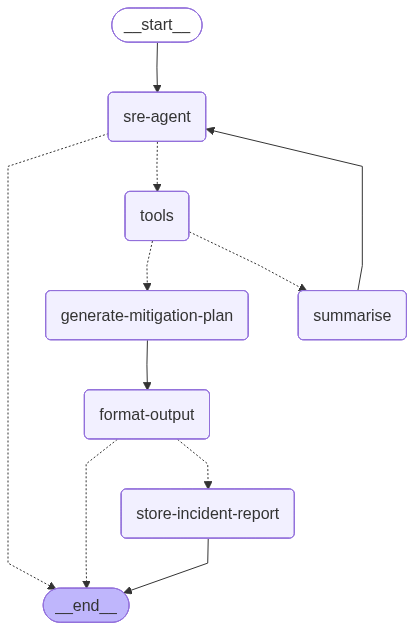

In [113]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Build the graph
builder = StateGraph(SREAgentState)

# Add nodes
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(tools_with_completion)) # Tool node is executing the tool called in the previous message
builder.add_node("summarise", summarise) # Node to reduce the raw data into a schema
builder.add_node("generate-mitigation-plan", mitigation_planner)
builder.add_node("format-output", format_response)
builder.add_node("store-incident-report", store_incident_report)

# Add edges
builder.add_edge(START, "sre-agent")

# Conditional edge from sre-agent
builder.add_conditional_edges(
    "sre-agent",
    #Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
    tools_condition,
)

# After tools, decide whether to summarise or end
def after_tools_condition(state: SREAgentState):
    # If response is filled, investigation is complete (end of the workflow)
    if state.get("response"):
        return "generate-mitigation-plan"
    return "summarise"

builder.add_conditional_edges(
    "tools",
    after_tools_condition,
    {
        "summarise": "summarise",
        "generate-mitigation-plan": "generate-mitigation-plan"
    }
)

# If is a new incident, store in VectorDB
def new_incident_condition(state: SREAgentState):
    if state['is_already_happened']:
        return END
    else:
        return "store-incident-report"
    
builder.add_conditional_edges(
    "format-output",
    new_incident_condition,
    {
        "store-incident-report": "store-incident-report",
        END: END
    }
)

# After summarise, continue investigation (go to sre-agent)
builder.add_edge("summarise", "sre-agent")
builder.add_edge("generate-mitigation-plan", "format-output")
builder.add_edge("format-output", END)
builder.add_edge("store-incident-report", END)

# Compile the graph
structured_graph = builder.compile()

# Show the graph
display(Image(structured_graph.get_graph(xray=True).draw_mermaid_png()))

In [114]:
from datetime import datetime

def save_markdown_file(structured_result, trace_name):
    
    # Get the output path from environment variable
    output_path = os.getenv("RESULTS_PATH")
    if not output_path:
        raise ValueError("Environment variable not set")
    

    # Generate timestamp for filename and title
    now = datetime.now()
    filename_timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
    title_timestamp = now.strftime("%Y-%m-%d %H:%M:%S")
    
    # Create filename
    filename = f"{filename_timestamp}.md"
    filepath = output_path + "/" + filename
    
    # Get markdown content
    markdown_content = structured_result.get("final_output", "")
    
    # Create the complete file content with title header
    file_content = f"""# {title_timestamp} - {trace_name}

{markdown_content}"""
    
    # Write to file
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(file_content)
    
    print(f"Markdown file saved: {filepath}")
    return str(filepath)

In [115]:
import time

async def test_structured_graph(graph, app_summary:str, human_message: str = "", trace_name: str = None):
    """Test the structured graph with SREAgentState"""
    # Create initial state with SREAgentState structure
    initial_state = {
        "messages": [HumanMessage(content=human_message)] if human_message else [],
        "insights": [],
        "prev_steps": [],
        "response": "",
        "final_output" : "",
        "app_summary" : app_summary,
        "mitigation_plan_overview" : "",
        "mitigation_steps" : [],
        "is_already_happened" : False
    }
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke(initial_state, config)

    # Calculate execution time
    execution_time = time.time() - start_time

    save_markdown_file(result, trace_name)

    return result

In [116]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE structured format agent"

In [117]:
app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [118]:
human = ""
structured_result = await test_structured_graph(structured_graph, app_summary, human, experiment_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

GraphRecursionError: Recursion limit of 50 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
structured_result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EU15IImT9KNUbPZoI9dKBltp', 'function': {'arguments': '{"resourceType":"pods","name":"","namespace":"default","allNamespaces":true,"output":"wide"}', 'name': 'kubectl_get'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 1253, 'total_tokens': 1294, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-C9ArYd3E221zUT1iXSKfh439hei2C', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--34c378a7-47a9-4f88-9460-de06eb666573-0', tool_calls=[{'name': 'kubectl_get', 'args': {'resourceType': 'pods', 'name': '', 'namespace': 'default', 'allNamespaces': True, 'output': 'wide'}, 'id'

In [ ]:
from IPython.display import Markdown, display

display(Markdown(structured_result["final_output"]))

# 📝 Results of the Analysis

## 🔍 Steps Performed
- Used kubectl_get to run 'kubectl get pods --all-namespaces -o wide' to list pod statuses and details.
- Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' to inspect container state, exit code, and events.
- Fetched the container logs using kubectl_logs for pod geo-6b4b89b5f5-v44q4 (container hotel-reserv-geo) in namespace test-hotel-reservation (tail=500).
- Ran kubectl_get to list pods in namespace test-hotel-reservation (kubectl get pods -n test-hotel-reservation -o wide).
- Ran kubectl_get to fetch Service resources in namespace test-hotel-reservation (kubectl get services -n test-hotel-reservation -o yaml).

## 💡 Insights Gathered
- Pod 'geo' in namespace 'test-hotel-reservation' is in CrashLoopBackOff (0/1) with 8 restarts — indicates a failing container likely causing the incident.
- Container 'hotel-reserv-geo' in pod test-hotel-reservation/geo-6b4b89b5f5-v44q4 is in CrashLoopBackOff (RestartCount=8); last termination Exit Code 2 (Error). Image pulls succeed, so this is likely an application runtime failure — collect container logs and check startup args/config.
- The geo service is panicking on startup because it cannot connect to its MongoDB at mongodb-geo:27777 (“no reachable servers”), causing the container to exit and the pod to CrashLoopBackOff.
- The mongodb-geo pod is Running (1/1, 0 restarts) at 10.244.1.33 while the geo pod remains in CrashLoopBackOff — the MongoDB process appears healthy, so the geo app’s inability to connect is more likely due to service/port/DNS or network/config issues (not MongoDB being down).
- The mongodb-geo Service exists in namespace test-hotel-reservation (clusterIP 10.96.245.81) and exposes MongoDB on port 27017 — but the geo app was attempting to connect to mongodb-geo:27777. This port mismatch likely causes the “no reachable servers” error and the geo pod CrashLoopBackOff.

## 🚨 Final Report (Root Cause)
> Diagnosis:
The geo service (pod test-hotel-reservation/geo-6b4b89b5f5-v44q4, container hotel-reserv-geo) is crashing because it cannot connect to MongoDB: it attempts to reach mongodb-geo:27777 but the MongoDB Service exposes port 27017. This port mismatch causes the application to fail the DB connection (error “no reachable servers”), panic on startup, exit with code 2, and enter CrashLoopBackOff.

Reasoning:
Observed evidence: the geo pod is CrashLoopBackOff with RestartCount=8 and last termination Exit Code 2. Geo container logs show MongoDB connection failures ("no reachable servers"). The mongodb-geo pod is Running (1/1, 0 restarts) with an IP (10.244.1.33), indicating the DB process itself is healthy. The mongodb-geo Service exists in namespace test-hotel-reservation (ClusterIP 10.96.245.81) and its target port is 27017. However, the geo application tries to connect to mongodb-geo:27777 (different port). Because the service port and the application's configured port do not match, the geo app cannot reach MongoDB and fails during startup. This indicates a configuration mismatch (wrong port in geo config or incorrect Service port) rather than MongoDB being down.

## 🛠️ Mitigation Plan Strategy
Root cause: geo app configured to connect to mongodb-geo:27777 while mongodb-geo Service exposes 27017. Recommended mitigation is to update the geo deployment/configmap to use port 27017 and restart the deployment. As a temporary emergency workaround, you may patch the mongodb-geo Service port to 27777 (short-lived, higher risk). Verify rollout, logs, and connectivity, and follow up with config, CI and monitoring changes to prevent recurrence.

## 📋 Detailed Mitigation Steps
1. Overview: The geo pod is CrashLoopBackOff because it is configured to connect to mongodb-geo:27777 while the mongodb-geo Service exposes 27017. Fix the configuration (recommended) or temporarily patch the Service (workaround).
2. Step 1 — Confirm current state: kubectl -n test-hotel-reservation get pods, kubectl -n test-hotel-reservation get svc mongodb-geo -o yaml, kubectl -n test-hotel-reservation describe pod <geo-pod> and kubectl -n test-hotel-reservation logs <geo-pod> -c hotel-reserv-geo --tail=200
3. Step 2 — Find where 27777 is configured: kubectl -n test-hotel-reservation get deploy geo -o yaml | grep -n "27777" || true; kubectl -n test-hotel-reservation get cm -o yaml | grep -n "27777" || true; kubectl -n test-hotel-reservation get deploy geo -o yaml | grep -n "MONGO" || true
4. Step 3 — Recommended fix (Option A): update geo config to use port 27017. If the port is an env var: kubectl -n test-hotel-reservation set env deployment/geo MONGO_PORT=27017 or kubectl -n test-hotel-reservation edit deployment geo and change 27777 → 27017; if in a ConfigMap, kubectl -n test-hotel-reservation edit configmap <name> and change the value, then force a rollout: kubectl -n test-hotel-reservation rollout restart deployment geo
5. Step 4 — Verify rollout & logs: kubectl -n test-hotel-reservation rollout status deployment geo; kubectl -n test-hotel-reservation get pods -l io.kompose.service=geo; kubectl -n test-hotel-reservation logs <geo-pod> -c hotel-reserv-geo --tail=200 — confirm successful Mongo connection and no panic
6. Step 5 — Connectivity test (optional): kubectl -n test-hotel-reservation run --rm -it test-net --image=nicolaka/netshoot --restart=Never -- /bin/bash; inside: nc -vz mongodb-geo 27017 or use a mongo client to ping the DB
7. Step 6 — If immediate restore is required and app change is not possible, temporary workaround (Option B): patch the Service port to 27777 while keeping targetPort 27017: kubectl -n test-hotel-reservation patch svc mongodb-geo --type='json' -p='[{"op":"replace","path":"/spec/ports/0/port","value":27777}]' or kubectl -n test-hotel-reservation edit svc mongodb-geo and change spec.ports[0].port to 27777. Verify pods and geo logs afterwards. NOTE: this is temporary and may break other consumers expecting 27017.
8. Step 7 — If changes cause regression: rollback deployment: kubectl -n test-hotel-reservation rollout undo deployment geo; if Service was patched, revert to port 27017 via edit or patch.
9. Step 8 — Collect diagnostics if issue persists: kubectl -n test-hotel-reservation logs <geo-pod> --previous -c hotel-reserv-geo; kubectl -n test-hotel-reservation describe pod <geo-pod>; kubectl -n test-hotel-reservation get events --sort-by='.lastTimestamp'; capture pre/post YAML of deployment/configmap/service for root-cause analysis
10. Step 9 — Post-remediation validation & cleanup: ensure geo pod is Running and Ready; run application smoke tests (via frontend or curl) to exercise geo flows; if Service was patched as workaround, revert it and ensure app config is fixed; update version control/Helm values with corrected port and pipeline
11. Step 10 — Prevent recurrence (follow-up tasks): centralize DB connection config (single ConfigMap/Secret or Helm values), add startup retries and clearer health checks to geo, add CI checks to validate host:port connectivity in staging, add alerting for CrashLoopBackOff with context and search rules for non-standard DB ports


In [ ]:
for step in structured_result["prev_steps"]:
    print(step)

Used kubectl_get to run 'kubectl get pods --all-namespaces -o wide' to list pod statuses and details.
Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' to inspect container state, exit code, and events.
Fetched the container logs using kubectl_logs for pod geo-6b4b89b5f5-v44q4 (container hotel-reserv-geo) in namespace test-hotel-reservation (tail=500).
Ran kubectl_get to list pods in namespace test-hotel-reservation (kubectl get pods -n test-hotel-reservation -o wide).
Ran kubectl_get to fetch Service resources in namespace test-hotel-reservation (kubectl get services -n test-hotel-reservation -o yaml).


In [ ]:
for insight in structured_result["insights"]:
    print(insight)

Pod 'geo' in namespace 'test-hotel-reservation' is in CrashLoopBackOff (0/1) with 8 restarts — indicates a failing container likely causing the incident.
Container 'hotel-reserv-geo' in pod test-hotel-reservation/geo-6b4b89b5f5-v44q4 is in CrashLoopBackOff (RestartCount=8); last termination Exit Code 2 (Error). Image pulls succeed, so this is likely an application runtime failure — collect container logs and check startup args/config.
The geo service is panicking on startup because it cannot connect to its MongoDB at mongodb-geo:27777 (“no reachable servers”), causing the container to exit and the pod to CrashLoopBackOff.
The mongodb-geo pod is Running (1/1, 0 restarts) at 10.244.1.33 while the geo pod remains in CrashLoopBackOff — the MongoDB process appears healthy, so the geo app’s inability to connect is more likely due to service/port/DNS or network/config issues (not MongoDB being down).
The mongodb-geo Service exists in namespace test-hotel-reservation (clusterIP 10.96.245.81) a

In [ ]:
print(structured_result["response"])

Diagnosis:
The geo service (pod test-hotel-reservation/geo-6b4b89b5f5-v44q4, container hotel-reserv-geo) is crashing because it cannot connect to MongoDB: it attempts to reach mongodb-geo:27777 but the MongoDB Service exposes port 27017. This port mismatch causes the application to fail the DB connection (error “no reachable servers”), panic on startup, exit with code 2, and enter CrashLoopBackOff.

Reasoning:
Observed evidence: the geo pod is CrashLoopBackOff with RestartCount=8 and last termination Exit Code 2. Geo container logs show MongoDB connection failures ("no reachable servers"). The mongodb-geo pod is Running (1/1, 0 restarts) with an IP (10.244.1.33), indicating the DB process itself is healthy. The mongodb-geo Service exists in namespace test-hotel-reservation (ClusterIP 10.96.245.81) and its target port is 27017. However, the geo application tries to connect to mongodb-geo:27777 (different port). Because the service port and the application's configured port do not match,

In [ ]:
print(structured_result["mitigation_plan_overview"])

Root cause: geo app configured to connect to mongodb-geo:27777 while mongodb-geo Service exposes 27017. Recommended mitigation is to update the geo deployment/configmap to use port 27017 and restart the deployment. As a temporary emergency workaround, you may patch the mongodb-geo Service port to 27777 (short-lived, higher risk). Verify rollout, logs, and connectivity, and follow up with config, CI and monitoring changes to prevent recurrence.


In [ ]:
for message in structured_result["messages"]:
    message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_EU15IImT9KNUbPZoI9dKBltp)
 Call ID: call_EU15IImT9KNUbPZoI9dKBltp
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS             RESTARTS     AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-6vmbw                                             0/1     Completed          0            24m   10.244.1.50   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-4r9cb                                   1/1     Running            0            39m   10.244.0.2    kind-control-plane   <none>           <none>
kube-system              coredns-668d6b